<a href="https://colab.research.google.com/github/ArthurChan-1111/Bitcoin_prediction/blob/main/Master_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!git clone https://github.com/ArthurChan-1111/Bitcoin_prediction.git

%cd Bitcoin_prediction

import pandas as pd
import numpy as np

df_bitcoin_by_day = pd.read_csv('btc_1d_data_2018_to_2025.csv', on_bad_lines='skip', lineterminator='\n')


1071.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
正複製到 'Bitcoin_prediction'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 7), reused 3 (delta 1), pack-reused 0 (from 0)
接收物件中: 100% (24/24), 177.18 KiB | 1.88 MiB/s, 完成.
處理 delta 中: 100% (7/7), 完成.
/Users/arthurchan/Documents/STAT5102/Project/Bitcoin_prediction/Bitcoin_prediction/Bitcoin_prediction


In [8]:
df_bitcoin_by_day.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2638.0,3.007471e+04,2.462686e+04,3.211710e+03,9.141495e+03,2.316573e+04,4.456562e+04,1.061438e+05
High,2638.0,3.076510e+04,2.511586e+04,3.276500e+03,9.304870e+03,2.373610e+04,4.616359e+04,1.083530e+05
Low,2638.0,2.933413e+04,2.411405e+04,3.156260e+03,8.874750e+03,2.270910e+04,4.336132e+04,1.053215e+05
Close,2638.0,3.010409e+04,2.465340e+04,3.211720e+03,9.141368e+03,2.317984e+04,4.466510e+04,1.061438e+05
Volume,2638.0,6.986922e+04,8.017029e+04,4.811771e+02,2.935439e+04,4.436260e+04,7.258744e+04,7.607054e+05
Quote asset volume,2638.0,1.806400e+09,2.007644e+09,1.177017e+07,3.825199e+08,1.126328e+09,2.526423e+09,1.746531e+10
Number of trades,2638.0,1.740156e+06,2.117254e+06,1.241700e+04,4.140775e+05,1.018162e+06,1.931050e+06,1.522359e+07
Taker buy base asset volume,2638.0,3.472933e+04,3.989757e+04,2.313948e+02,1.478038e+04,2.222689e+04,3.584608e+04,3.747756e+05
Taker buy quote asset volume,2638.0,8.943653e+08,9.983054e+08,6.532639e+06,1.907035e+08,5.474179e+08,1.260436e+09,8.783916e+09
Ignore,2638.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [9]:
def calculate_indicators(df):
    # Calculate RSI
    def rsi(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    # Calculate CCI
    def cci(series, period=14):
        typical_price = (series['High'] + series['Low'] + series['Close']) / 3
        ma = typical_price.rolling(window=period).mean()
        mad = (typical_price - ma).abs().rolling(window=period).mean()
        return (typical_price - ma) / (0.015 * mad)

    # Calculate Bollinger Bands
    def bollinger_bands(series, window=20, num_std_dev=2):
        sma = series['Close'].rolling(window=window).mean()
        rstd = series['Close'].rolling(window=window).std()
        upper_band = sma + (rstd * num_std_dev)
        lower_band = sma - (rstd * num_std_dev)
        return upper_band, lower_band

    # Calculating indicators
    df['RSI7'] = rsi(df['Close'], period=7)
    df['RSI14'] = rsi(df['Close'], period=14)
    df['CCI7'] = cci(df, period=7)
    df['CCI14'] = cci(df, period=14)
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['Bollinger_Upper'], df['Bollinger_Lower'] = bollinger_bands(df)

    #Cup and handle signal
    df['Cup_Handle_Signal'] = 0  # Initialize signal column with 0

    for i in range(20, len(df) - 10):  # Start from index 20 to ensure enough data for the pattern
        # Define the cup pattern
        cup_start = i - 20  # Look back 20 periods for the start of the cup
        cup_end = i  # Current index is the end of the cup
        handle_start = i + 1  # Start of the handle
        handle_end = i + 10  # End of the handle (10 periods forward)

        # Check for a rounded cup shape
        cup_prices = df['Close'].iloc[cup_start:cup_end + 1]
        cup_bottom = cup_prices.min()
        cup_top = max(cup_prices.iloc[0], cup_prices.iloc[-1])  # Top of the cup (start and end prices)
        cup_depth = cup_top - cup_bottom

        # Ensure the cup is rounded (symmetry check)
        left_side = cup_prices.iloc[:len(cup_prices) // 2]
        right_side = cup_prices.iloc[len(cup_prices) // 2:]
        if not (left_side.mean() > cup_bottom and right_side.mean() > cup_bottom):
            continue  # Skip if the cup is not rounded

        # Check for the handle pattern
        handle_prices = df['Close'].iloc[handle_start:handle_end + 1]
        handle_slope = (handle_prices.iloc[-1] - handle_prices.iloc[0]) / len(handle_prices)

        # Ensure the handle has a slight downward slope
        if handle_slope >= 0:
            continue  # Skip if the handle does not slope downward

        # Ensure the handle does not drop below 50% of the cup depth
        if handle_prices.min() < cup_bottom + 0.5 * cup_depth:
            continue  # Skip if the handle drops too far

        # Record the Cup and Handle signal
        df.loc[handle_end, 'Cup_Handle_Signal'] = 1  # Mark the end of the handle as the signal point

    #/Cup and handle signal

    # Set Binary Signal
    df['Signal_Up'] = 0

    # Use .loc for assignment to avoid warnings
    df.loc[1:, 'Signal_Up'] = np.where(df['Close'].iloc[1:].values > df['Close'].iloc[:-1].values, 1, 0)


    # Add a column to indicate if the price rose by 5% or more compared to the previous day
    df_bitcoin_by_day['Signal_5Percent_Up'] = 0  # Initialize with 0

    # Use .loc for assignment to avoid warnings
    df_bitcoin_by_day.loc[1:, 'Signal_5Percent_Up'] = np.where(
        (df_bitcoin_by_day['Close'].iloc[1:].values >= df_bitcoin_by_day['Close'].iloc[:-1].values * 1.05),
        1,
        0
    )
    return df

calculate_indicators(df_bitcoin_by_day)

df_bitcoin_by_day.tail()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,RSI7,RSI14,CCI7,CCI14,MA50,Bollinger_Upper,Bollinger_Lower,Cup_Handle_Signal,Signal_Up,Signal_5Percent_Up
2633,2025-03-18,84010.02,84021.74,83017.88,83018.33,1110.53302,2025-03-18 23:59:59.999,9.266588e+07,179190,436.70291,...,68.363371,41.512263,3.070044,-29.091901,92459.5592,92228.296511,78262.968489,0,0,0
2634,2025-03-19,82715.03,83280.00,82603.20,83010.87,1360.52066,2025-03-19 23:59:59.999,1.129231e+08,209016,829.38438,...,46.272092,33.562588,-25.112016,-27.920901,92093.0662,92100.209554,78046.600446,0,0,0
2635,2025-03-20,86845.93,87453.67,85733.11,85905.91,3146.08729,2025-03-20 23:59:59.999,2.723224e+08,399959,1421.72638,...,61.212357,41.838930,151.593782,67.947207,91736.5196,92177.214055,78294.227945,0,1,0
2636,2025-03-21,84223.38,84748.44,84180.09,84711.21,656.96798,2025-03-21 23:59:59.999,5.548234e+07,117589,341.94482,...,69.261525,45.401429,29.070907,27.628368,91336.2850,92181.597884,78303.586116,0,0,0
2637,2025-03-22,84088.79,84338.98,83989.58,84037.82,534.27259,2025-03-22 23:59:59.999,4.496609e+07,86830,231.88751,...,48.410583,44.864757,4.511839,21.414159,90968.4502,90226.130479,79235.835521,0,0,0


In [10]:
df_bitcoin_by_day[df_bitcoin_by_day['Signal_Up']==1]

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,RSI7,RSI14,CCI7,CCI14,MA50,Bollinger_Upper,Bollinger_Lower,Cup_Handle_Signal,Signal_Up,Signal_5Percent_Up
1,2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,2018-01-02 23:59:59.999,2.797171e+08,177728,11346.326739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
2,2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639,2018-01-03 23:59:59.999,2.361169e+08,162787,8994.953566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
3,2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.649574,2018-01-04 23:59:59.999,3.127816e+08,170310,12680.812951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
4,2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,2018-01-05 23:59:59.999,3.693220e+08,192969,13346.622293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
5,2018-01-06,16960.39,17143.13,16011.21,17069.79,18571.457508,2018-01-06 23:59:59.999,3.092169e+08,158242,11007.164056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620,2025-03-05,87281.98,90933.82,86334.53,90283.57,36649.484150,2025-03-05 23:59:59.999,3.254229e+09,7716640,18359.331920,...,60.149200,44.278219,40.253500,-23.914560,97367.9326,103117.912039,81965.731961,0,1,0
2627,2025-03-12,82932.99,83591.07,82604.95,83488.72,1624.191460,2025-03-12 23:59:59.999,1.349775e+08,311866,977.529250,...,28.378680,49.162174,-32.037434,-39.030067,94897.7358,99531.739980,77298.730020,0,1,1
2628,2025-03-13,83680.12,84000.00,83312.92,83915.10,1854.128840,2025-03-13 23:59:59.999,1.552110e+08,273157,940.659960,...,30.945065,47.090678,-0.568450,-32.759954,94501.9046,97947.414677,77444.565323,0,1,0
2630,2025-03-15,83983.19,84583.04,83964.57,84227.92,782.819720,2025-03-15 23:59:59.999,6.596448e+07,131694,425.748270,...,43.619037,49.595132,40.758207,-29.557826,93644.6198,95043.867155,77656.577845,0,1,0


In [11]:
df_bitcoin_by_day[df_bitcoin_by_day['Signal_5Percent_Up']==1]

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,RSI7,RSI14,CCI7,CCI14,MA50,Bollinger_Upper,Bollinger_Lower,Cup_Handle_Signal,Signal_Up,Signal_5Percent_Up
1,2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,2018-01-02 23:59:59.999,2.797171e+08,177728,11346.326739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
4,2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,2018-01-05 23:59:59.999,3.693220e+08,192969,13346.622293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
19,2018-01-20,11474.98,13099.00,11412.45,12799.94,28768.857827,2018-01-20 23:59:59.999,3.585611e+08,251647,14389.196005,...,36.928057,30.954953,28.910079,NaN,NaN,17560.179217,10215.159783,0,1,1
23,2018-01-24,10799.14,11570.48,10500.00,11349.99,27158.587762,2018-01-24 23:59:59.999,2.994706e+08,293429,13087.393088,...,54.018137,33.320079,-19.936438,NaN,NaN,17383.720292,9032.124708,0,1,1
36,2018-02-06,6939.63,7878.00,6000.01,7652.14,100201.500307,2018-02-06 23:59:59.999,6.843643e+08,785996,49565.020794,...,22.835390,30.340584,-69.165579,-142.530181,NaN,13417.628766,7298.310234,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,2024-11-06,69372.01,76400.00,69298.00,75571.99,104126.994787,2024-11-06 23:59:59.999,7.702283e+09,8434184,53243.884427,...,63.208343,70.537266,165.962242,188.375440,65715.1014,73606.891524,64702.842476,0,1,1
2506,2024-11-11,80370.01,89530.54,80216.01,88647.99,82323.665776,2024-11-11 23:59:59.999,6.944269e+09,9348890,42837.295314,...,100.000000,82.829760,133.646642,220.988960,67379.6290,83108.094125,60943.803875,0,1,1
2577,2025-01-21,102260.00,107240.81,100119.04,106143.82,45941.020020,2025-01-21 23:59:59.999,4.768512e+09,6842980,23227.027410,...,74.440516,66.180939,48.817859,136.925247,98354.8208,106095.737591,90920.631409,0,1,1
2617,2025-03-02,86064.54,95000.00,85050.60,94270.00,54889.090450,2025-03-02 23:59:59.999,4.972550e+09,7403218,29273.810310,...,46.374818,47.460192,41.397778,-17.564925,97805.0498,104169.665347,83781.596653,0,1,1


In [12]:
df_bitcoin_by_day[df_bitcoin_by_day['Cup_Handle_Signal']==1]

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,RSI7,RSI14,CCI7,CCI14,MA50,Bollinger_Upper,Bollinger_Lower,Cup_Handle_Signal,Signal_Up,Signal_5Percent_Up
54,2018-02-24,10131.04,10496.97,9352.00,9694.51,40888.156299,2018-02-24 23:59:59.999,4.056186e+08,337918,18646.870961,...,31.422921,57.446809,-66.253706,-3.647601,10925.0052,11887.569418,6728.535582,1,0,0
55,2018-02-25,9694.51,9847.00,9274.80,9590.00,28373.517586,2018-02-25 23:59:59.999,2.712866e+08,233567,13956.661533,...,37.071581,60.274771,-82.110175,-28.755706,10775.4094,11767.815115,7113.290885,1,0,0
56,2018-02-26,9590.00,10444.32,9350.00,10324.00,34878.292756,2018-02-26 23:59:59.999,3.475593e+08,285276,17045.768706,...,36.333573,59.704402,-24.435789,-4.486290,10658.8888,11772.318603,7375.973397,1,1,1
58,2018-02-28,10584.33,11098.00,10300.00,10326.76,30800.983782,2018-02-28 23:59:59.999,3.279147e+08,277886,14412.846330,...,47.954166,56.707699,61.180738,15.630360,10490.7540,11678.375207,8021.194793,1,0,0
59,2018-03-01,10325.64,11060.41,10240.00,10920.00,25092.553930,2018-03-01 23:59:59.999,2.681725e+08,230428,12785.404500,...,70.723576,56.991590,70.334153,24.488922,10411.0122,11763.277766,8159.900234,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2583,2025-01-27,102620.01,103260.00,97777.77,102082.83,50758.134100,2025-01-27 23:59:59.999,5.092886e+09,9368910,23529.224330,...,58.124510,63.467603,-124.209777,-21.802716,98952.2632,108906.208229,91210.549771,1,0,0
2586,2025-01-30,103733.25,106457.44,103278.54,104722.94,19374.074720,2025-01-30 23:59:59.999,2.038113e+09,3990075,10140.928340,...,55.154417,59.219937,74.009267,26.706453,99248.2078,108848.083276,94013.923724,1,1,0
2587,2025-01-31,104722.94,106012.00,101560.00,102429.56,21983.181930,2025-01-31 23:59:59.999,2.282174e+09,4331904,10697.399680,...,36.756737,46.550263,7.200056,-0.908156,99296.7132,108512.322769,95132.641231,1,0,0
2588,2025-02-01,102429.56,102783.71,101412.00,102224.00,5132.366100,2025-02-01 23:59:59.999,5.245550e+08,1031097,2449.652790,...,36.432920,45.061248,-47.179967,-26.600393,99312.7082,107952.519570,96460.338430,1,0,0


In [13]:
# Filter rows where Cup_Handle_Signal is 1
cup_handle_signal_df = df_bitcoin_by_day[df_bitcoin_by_day['Cup_Handle_Signal'] == 1]

# Calculate probabilities
prob_signal_up = cup_handle_signal_df['Signal_Up'].mean()
prob_signal_5percent_up = cup_handle_signal_df['Signal_5Percent_Up'].mean()

print(f"Probability of Signal_Up when Cup_Handle_Signal is 1: {prob_signal_up:.2%}")
print(f"Probability of Signal_5Percent_Up when Cup_Handle_Signal is 1: {prob_signal_5percent_up:.2%}")

Probability of Signal_Up when Cup_Handle_Signal is 1: 37.65%
Probability of Signal_5Percent_Up when Cup_Handle_Signal is 1: 2.78%


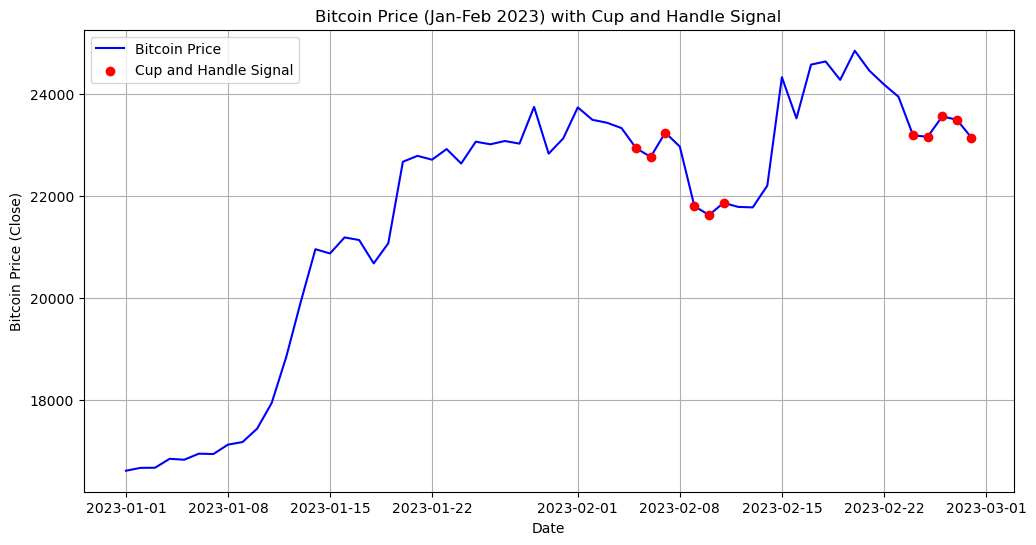

In [16]:
import matplotlib.pyplot as plt

# Filter data for January and February 2023
filtered_data = df_bitcoin_by_day[
    (df_bitcoin_by_day['Open time'] >= '2023-01-01') & 
    (df_bitcoin_by_day['Open time'] <= '2023-02-28')
]

# Plot Bitcoin price
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Open time'], filtered_data['Close'], label='Bitcoin Price', color='blue')

# Highlight Cup and Handle signals
cup_handle_data = filtered_data[filtered_data['Cup_Handle_Signal'] == 1]
plt.scatter(cup_handle_data['Open time'], cup_handle_data['Close'], color='red', label='Cup and Handle Signal', zorder=5)

# Add labels and legend
plt.title('Bitcoin Price (Jan-Feb 2023) with Cup and Handle Signal')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (Close)')
plt.legend()
plt.grid(True)
plt.show()